In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', '{:.2f}'.format)

In [210]:
dt = pd.read_csv("F:/Kaggle/E-commerce-Analysis/Pakistan Largest Ecommerce Dataset.csv")
dt.info()

c:\Users\LiangYu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1,2,3,7,8,9,11,12,13,14,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   item_id                584524 non-null  float64
 1   status                 584509 non-null  object 
 2   created_at             584524 non-null  object 
 3   sku                    584504 non-null  object 
 4   price                  584524 non-null  float64
 5   qty_ordered            584524 non-null  float64
 6   grand_total            584524 non-null  float64
 7   increment_id           584524 non-null  object 
 8   category_name_1        584360 non-null  object 
 9   sales_commission_code  447349 non-null  object 
 10  discount_amount        584524 non-null  float64
 11  payment_method         584524 non-null  object 
 12  Working Date           584524 non-null  object 
 13  BI Status              584524 non-null  object 
 14   MV                    584524 non-

In [211]:
#保留需要的columns，並且刪除整行是空值的欄位
dt = dt.loc[:,["item_id", "status", "created_at", "sku", "price", "qty_ordered", "grand_total", "increment_id", "category_name_1","discount_amount", \
    "payment_method", "Year", "Month", "Customer ID"]]
dt = dt.dropna(how = 'all')

In [212]:
#另有11筆資料缺少會員id，也將這些訂單資料刪除。
#dt[dt["Customer ID"].isna()]
dt = dt.dropna(subset=["Customer ID"])

In [213]:
dt.describe()

,item_id,price,qty_ordered,grand_total,discount_amount,Year,Month,Customer ID
count,584513.00,584513.00,584513.00,584513.00,584513.00,584513.00,584513.00,584513.00
mean,565663.13,6348.82,1.30,8530.68,499.50,2017.04,7.17,45790.51
std,200120.93,14949.40,4.00,61321.38,1506.96,0.71,3.49,34414.96
min,211131.00,0.00,1.00,-1594.00,-599.50,2016.00,1.00,1.00
25%,394997.00,360.00,1.00,945.00,0.00,2017.00,4.00,13516.00
50%,568417.00,899.00,1.00,1960.40,0.00,2017.00,7.00,42856.00
75%,739102.00,4070.00,1.00,6999.00,160.52,2018.00,11.00,73536.00
max,905208.00,1012625.90,1000.00,17888000.00,90300.00,2018.00,12.00,115326.00


In [214]:
dt.describe(include=['object','bool'])

,status,created_at,sku,increment_id,category_name_1,payment_method
count,584498,584513,584493,584513,584349,584513
unique,16,789,84888,408776,16,18
top,complete,11/25/2016,MATSAM59DB75ADB2F80,100266667,Mobiles & Tablets,cod
freq,233685,15169,3775,72,115710,271955


In [215]:
#檢查 status 內不同的分類，接著把意思相近的分類整理成 "已完成"、"取消"、"處理中"
dt["status"].unique()

array(['complete', 'canceled', 'order_refunded', 'received', 'refund',
       'closed', 'fraud', 'holded', 'exchange', 'pending_paypal', 'paid',
       '\\N', 'cod', 'pending', nan, 'processing', 'payment_review'],
      dtype=object)

In [216]:
dt["status"] = dt["status"].replace(
    {"complete": "completed",
    "received": "completed",
    "cod": "completed",
    "paid": "completed",
    "closed": "completed",
    "exchange": "completed",
    "canceled": "canceled",
    "order_refunded": "canceled",
    "refund": "canceled",
    "fraud": "canceled",
    "payment_review": "pending",
    "pending": "pending",
    "processing": "pending",
    "holded": "pending",
    "pending_paypal": "pending"})

In [217]:
#將部分columns轉換成正確的資料類型
dt["Customer ID"] = dt["Customer ID"].astype(int).astype(str)
dt["item_id"] = dt["item_id"].astype(str)
dt["qty_ordered"] = dt["qty_ordered"].astype(int)  
dt["Year"] = dt["Year"].astype(int)  
dt["Month"] = dt["Month"].astype(int)

In [218]:
#將消費日期轉為正確格式 %Y/%m/%m
dt["Day"] = dt["created_at"].str.split('/', expand=True)[1].apply(lambda x: x if len(x)>1 else "0"+x)
dt["Month"] = dt["Month"].astype(str).apply(lambda x: x if len(x)>1 else "0"+x)
dt["created_at"] = dt["Year"].astype(str) + "-" + dt["Month"] + "-" + dt["Day"].astype(str)
dt["created_at_date"] = pd.to_datetime(dt["created_at"])
print(dt["created_at_date"].min())
print(dt["created_at_date"].max())

2016-07-01 00:00:00
2018-08-28 00:00:00


In [219]:
#1 統計2016/07/01 - 2018/08/28 月營收
revenue = dt[dt["status"] == "completed"][["Year", "Month", "qty_ordered", "grand_total"]].groupby(["Year", "Month"]).agg("sum").sort_values(by=["Year", "Month"]).reset_index()
created_at_y_m = revenue["Year"].astype(str) + "-" + revenue["Month"]
revenue.insert(0,"Year_Month",created_at_y_m)
revenue

,Year_Month,Year,Month,qty_ordered,grand_total
0,2016-07,2016,07,6639,11720820.27
1,2016-08,2016,08,8506,17588479.23
2,2016-09,2016,09,9150,27503668.06
3,2016-10,2016,10,9074,24824142.90
4,2016-11,2016,11,42330,97895239.77
5,2016-12,2016,12,9125,26814176.77
6,2017-01,2017,01,9755,32184798.24
7,2017-02,2017,02,9422,30109818.33
8,2017-03,2017,03,13812,51529073.94
9,2017-04,2017,04,19237,44655625.57


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25],
 [Text(0, 0, '2016-07'),
  Text(1, 0, '2016-08'),
  Text(2, 0, '2016-09'),
  Text(3, 0, '2016-10'),
  Text(4, 0, '2016-11'),
  Text(5, 0, '2016-12'),
  Text(6, 0, '2017-01'),
  Text(7, 0, '2017-02'),
  Text(8, 0, '2017-03'),
  Text(9, 0, '2017-04'),
  Text(10, 0, '2017-05'),
  Text(11, 0, '2017-06'),
  Text(12, 0, '2017-07'),
  Text(13, 0, '2017-08'),
  Text(14, 0, '2017-09'),
  Text(15, 0, '2017-10'),
  Text(16, 0, '2017-11'),
  Text(17, 0, '2017-12'),
  Text(18, 0, '2018-01'),
  Text(19, 0, '2018-02'),
  Text(20, 0, '2018-03'),
  Text(21, 0, '2018-04'),
  Text(22, 0, '2018-05'),
  Text(23, 0, '2018-06'),
  Text(24, 0, '2018-07'),
  Text(25, 0, '2018-08')])

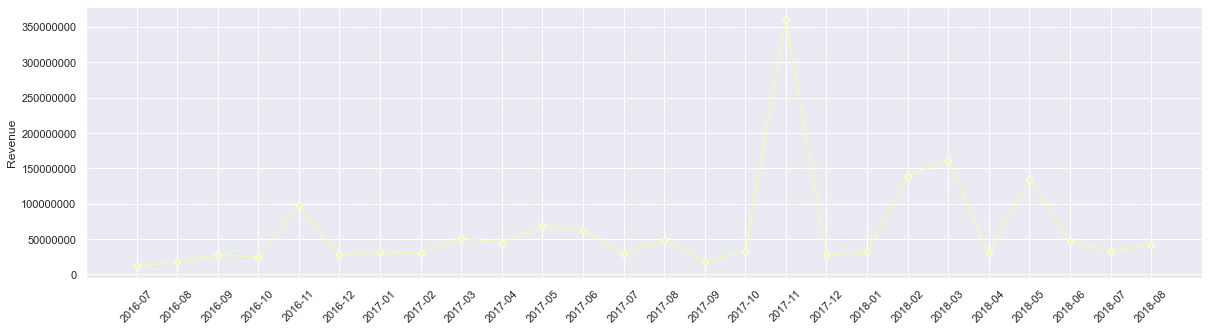

In [220]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.set(style="darkgrid", palette="YlGn")
sns.lineplot(data=revenue, x="Year_Month", y="grand_total",marker="o")
ax.yaxis.get_major_formatter().set_scientific(False)
#ax.yaxis.get_major_formatter().set_useOffset(False)
ax.set_xlabel('')
ax.set_ylabel('Revenue')
plt.xticks(rotation=45)

In [221]:
created_at_y_m = dt["Year"].astype(str) + "-" + dt["Month"]
dt.insert(0,"Year_Month",created_at_y_m)

In [222]:
#2 統計每月份客單價 每月收入/訂單總數
orders = dt[dt["status"] == "completed"].groupby("Year_Month")["increment_id"].nunique().reset_index()
revenue["total_order"] = orders["increment_id"]
revenue["AOV"] = revenue["grand_total"]/revenue["total_order"]
revenue[["Year_Month","grand_total","total_order","AOV"]]


,Year_Month,grand_total,total_order,AOV
0,2016-07,11720820.27,4930,2377.45
1,2016-08,17588479.23,6467,2719.73
2,2016-09,27503668.06,7035,3909.55
3,2016-10,24824142.90,6304,3937.84
4,2016-11,97895239.77,30544,3205.06
5,2016-12,26814176.77,6686,4010.50
6,2017-01,32184798.24,5922,5434.79
7,2017-02,30109818.33,4946,6087.71
8,2017-03,51529073.94,7442,6924.09
9,2017-04,44655625.57,7072,6314.43


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25],
 [Text(0, 0, '2016-07'),
  Text(1, 0, '2016-08'),
  Text(2, 0, '2016-09'),
  Text(3, 0, '2016-10'),
  Text(4, 0, '2016-11'),
  Text(5, 0, '2016-12'),
  Text(6, 0, '2017-01'),
  Text(7, 0, '2017-02'),
  Text(8, 0, '2017-03'),
  Text(9, 0, '2017-04'),
  Text(10, 0, '2017-05'),
  Text(11, 0, '2017-06'),
  Text(12, 0, '2017-07'),
  Text(13, 0, '2017-08'),
  Text(14, 0, '2017-09'),
  Text(15, 0, '2017-10'),
  Text(16, 0, '2017-11'),
  Text(17, 0, '2017-12'),
  Text(18, 0, '2018-01'),
  Text(19, 0, '2018-02'),
  Text(20, 0, '2018-03'),
  Text(21, 0, '2018-04'),
  Text(22, 0, '2018-05'),
  Text(23, 0, '2018-06'),
  Text(24, 0, '2018-07'),
  Text(25, 0, '2018-08')])

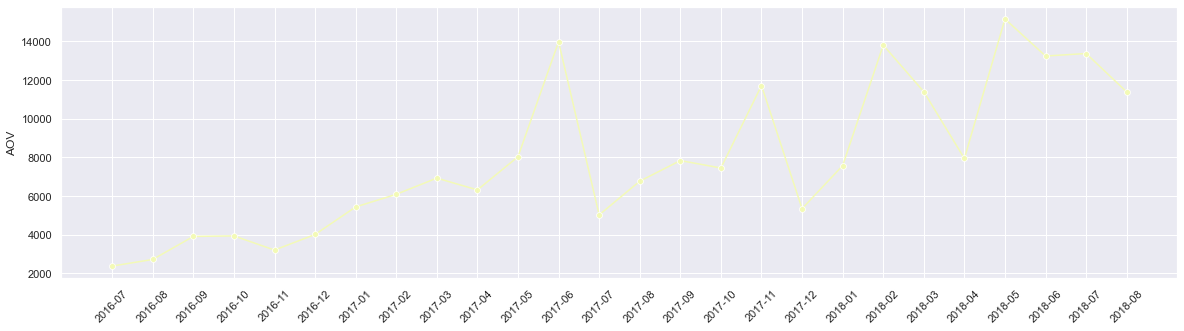

In [223]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.set(style="darkgrid", palette="YlGn")
sns.lineplot(data=revenue, x="Year_Month", y="AOV",marker="o")
ax.set_xlabel("")
ax.set_ylabel("AOV")
plt.xticks(rotation=45)

In [224]:
#3 統計每月份人均消費訂單數
customer_id_count = dt[dt["status"] == "completed"].groupby(["Year_Month"])["Customer ID"].nunique().reset_index()
customer_id_count["month_total_order"] = orders["increment_id"]
customer_id_count["month_capita_order"] = round(customer_id_count["month_total_order"]/customer_id_count["Customer ID"],2)
customer_id_count

,Year_Month,Customer ID,month_total_order,month_capita_order
0,2016-07,1622,4930,3.04
1,2016-08,2640,6467,2.45
2,2016-09,3772,7035,1.87
3,2016-10,2765,6304,2.28
4,2016-11,12811,30544,2.38
5,2016-12,3642,6686,1.84
6,2017-01,3212,5922,1.84
7,2017-02,3327,4946,1.49
8,2017-03,4919,7442,1.51
9,2017-04,4119,7072,1.72


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25],
 [Text(0, 0, '2016-07'),
  Text(1, 0, '2016-08'),
  Text(2, 0, '2016-09'),
  Text(3, 0, '2016-10'),
  Text(4, 0, '2016-11'),
  Text(5, 0, '2016-12'),
  Text(6, 0, '2017-01'),
  Text(7, 0, '2017-02'),
  Text(8, 0, '2017-03'),
  Text(9, 0, '2017-04'),
  Text(10, 0, '2017-05'),
  Text(11, 0, '2017-06'),
  Text(12, 0, '2017-07'),
  Text(13, 0, '2017-08'),
  Text(14, 0, '2017-09'),
  Text(15, 0, '2017-10'),
  Text(16, 0, '2017-11'),
  Text(17, 0, '2017-12'),
  Text(18, 0, '2018-01'),
  Text(19, 0, '2018-02'),
  Text(20, 0, '2018-03'),
  Text(21, 0, '2018-04'),
  Text(22, 0, '2018-05'),
  Text(23, 0, '2018-06'),
  Text(24, 0, '2018-07'),
  Text(25, 0, '2018-08')])

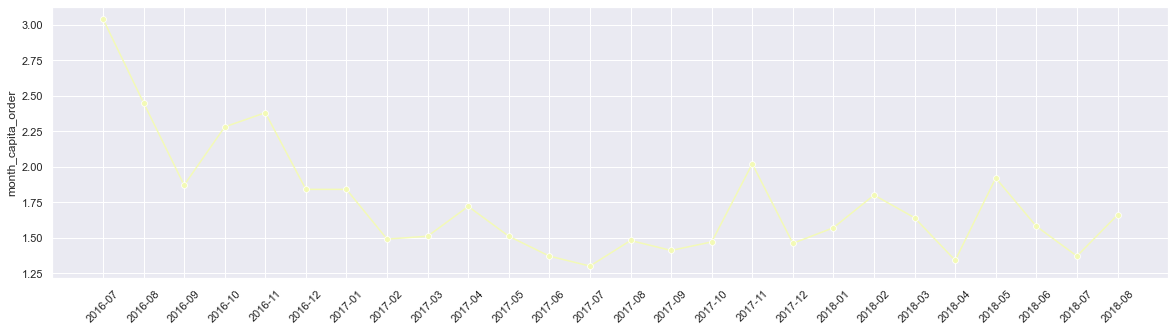

In [225]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.set(style="darkgrid", palette="YlGn")
sns.lineplot(data=customer_id_count, x="Year_Month", y="month_capita_order",marker="o")
ax.set_xlabel("")
ax.set_ylabel("month_capita_order")
plt.xticks(rotation=45)

In [261]:
#計算回購率
purchase_time = dt.pivot_table(index="Customer ID",columns="Year_Month",values="increment_id",aggfunc="nunique",fill_value=0)
purchase_time

Year_Month,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08
Customer ID,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100,2,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
1000,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10000,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
99996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,10,0,0,0,0,0
99997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [262]:
pivot_purchase = purchase_time.applymap(lambda x:1 if x>0 else 0)
pivot_backpurchase = (pivot_purchase.shift(-1,axis=1).fillna(0)+pivot_purchase).applymap(lambda x: 1 if x>1 else 0 )
pivot_backpurchase = pivot_backpurchase.shift(1,axis=1).fillna(0)
pivot_backpurchase.sum()/pivot_purchase.sum()

Year_Month
2016-07   0.00
2016-08   0.13
2016-09   0.11
2016-10   0.27
2016-11   0.07
2016-12   0.41
2017-01   0.23
2017-02   0.16
2017-03   0.13
2017-04   0.20
2017-05   0.13
2017-06   0.25
2017-07   0.20
2017-08   0.18
2017-09   0.28
2017-10   0.16
2017-11   0.07
2017-12   0.41
2018-01   0.20
2018-02   0.09
2018-03   0.11
2018-04   0.20
2018-05   0.11
2018-06   0.24
2018-07   0.17
2018-08   0.14
dtype: float64

dt.loc[:,["item_id", "status", "created_at", "sku", "price", "qty_ordered", "grand_total", "increment_id", "category_name_1","discount_amount", \
    "payment_method", "Year", "Month", "Customer ID"]]Year_Month
    pivot_purchase = pivot_purchase_times.applymap(lambda x: 1 if x>0  else  0)
pivot_backpurchase  =(pivot_purchase.shift(-1,axis=1).fillna(0)+pivot_purchase).applymap(lambda x: 1 if x>1 else 0 )
pivot_backpurchase.sum()/pivot_purchase.sum()
/9946

In [227]:
# shop_sum = revenue.groupby("invoice_date_y")["price"].agg("sum")
# customer_id_count = df.groupby("invoice_date_y")["invoice_no","customer_id"].nunique()
# customer_id_count
# shop_per_num =pd.concat([shop_sum,customer_id_count],axis=1)
# shop_per_num

In [228]:
#order_data = pd.merge(df_orders, df_order_payments, on="order_id")
# order_count = order_data[order_data["order_status"] != "canceled"].groupby("order_purchase_y").agg("count")
# customer_id_count = order_data[order_data["order_status"] != "canceled"].groupby("order_purchase_y")["customer_id"].nunique()
# order_count

新舊客戶 >> 生成最早購買時間欄位?
#4 每個月重複購買率
#5 每個月回購率v
#6 RFM模型

#7 商品銷量Top10
#8 商品退貨Top10
#9 付費方式占比



In [229]:
#2016 - 2018 人均訂單數
# customer_id
# order_count = order_data[order_data["order_status"] != "canceled"].groupby("order_purchase_y").agg("count")
# customer_id_count = order_data[order_data["order_status"] != "canceled"].groupby("order_purchase_y")["customer_id"].nunique()
# order_count


In [230]:
# customer_id_count


# grand_total_check = dt[dt["grand_total"] < 0]["status"].value_counts().rename_axis("status").reset_index(name="counts")
# #grand_total_check
# fig, ax = plt.subplots(figsize=(15,5))
# sns.set(style="darkgrid", palette="YlGn_r")
# g = sns.barplot(data=grand_total_check, x="status", y="counts")
# ax.bar_label(g.containers[0], padding = 0, fontsize = 12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.xlabel('Order Status', fontsize=12, labelpad=10)
# plt.ylabel('Counts', fontsize=12, labelpad=10)